In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# utilizado para la manipulación de directorios y rutas
import os
import torch
# Cálculo científico y vectorial para python
import numpy as np
import pandas as pd
# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

In [ ]:
'''DATOS DEL DATASET
# El Dataset corresponde a datos de LETRAS
# Las imágenes de son de 28x28
# El dataset cuenta con 26 etiquetas
# Cuenta con 145600 ejemplos
'''
# etiquetas
num_labels = 26
# se recupera los datos
data = loadmat('/content/drive/MyDrive/pasttimes/machinelearning/datasets/emnist-letters.mat')


In [ ]:
'''De la llave 'dataset' se extre los datos a una nueva variable,
este mismo tiene las llaves de Train  y Test'''

dataset = data['dataset']
print("Dataset shape:", dataset.shape)
print("Dataset data type:", dataset.dtype)

Dataset shape: (1, 1)
Dataset data type: [('train', 'O'), ('test', 'O'), ('mapping', 'O')]


In [ ]:
# Se extraen train y test del dataset
train_data = dataset['train'][0][0]
test_data = dataset['test'][0][0]


In [ ]:


print("Train data shape:", train_data.shape)
print("Train data type:", train_data.dtype)
print("Test data shape:", test_data.shape)
print("Test data type:", test_data.dtype)

'''
IMAGES : llegan a ser las X
LABELS : son las etiquetas osea el objetivo Y
WRITERS : son las imágenes de las letras sin ser procesadas'''

Train data shape: (1, 1)
Train data type: [('images', 'O'), ('labels', 'O'), ('writers', 'O')]
Test data shape: (1, 1)
Test data type: [('images', 'O'), ('labels', 'O'), ('writers', 'O')]


'\nIMAGES : llegan a ser las X\nLABELS : son las etiquetas osea el objetivo Y\nWRITERS : son las imágenes de las letras sin ser procesadas'

In [ ]:
'''Se almacenan las llaves 'images' y 'labels' en sus respectivas variables para los datos de entrenaiento y los de testeo'''

train_images = train_data['images'][0][0]
train_labels = train_data['labels'][0][0]
test_images = test_data['images'][0][0]
test_labels = test_data['labels'][0][0]

In [ ]:
'''SE RECUPERAN LOS DATOS

- Se están recuperando las filas hasta 20000 con todas sus columnas

- Este dataset cuenta con un total de 145000 ejemplos, el problema es
el tiempo de procesamiento, es muy largo para todos esos ejemplos'''

x_train= train_images[:50000, :]
# la fuanción ravel() es para convertir de una matriz unidimencional a un arreglo
y_train= train_labels[:50000].ravel()

x_test = test_images[:50000, :]
y_test = test_labels[:50000].ravel()
# convirtiendo el rango de 1-26 a 0-25
y_train[y_train == 26] = 0
y_test[y_test == 26] = 0

m = y_train.size


In [ ]:
# print(X_train)
# print(y_train[:100])

### 1.2 Visualización de los datos

Se comenzará visualizando un subconjunto del conjunto de entrenamiento. Se selecciona al azar, 100 filas de `X` y pasa esas filas a la función` displayData`. Esta función asigna cada fila a una imagen en escala de grises de 20 píxeles por 20 píxeles y muestra las imágenes juntas.

In [ ]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

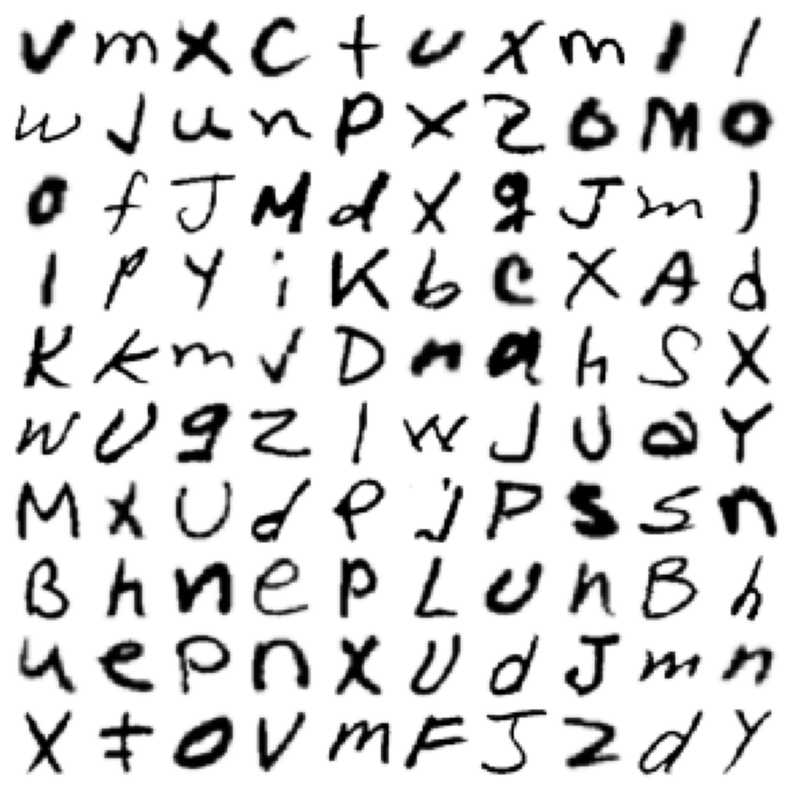

In [ ]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = x_train[rand_indices, :]

displayData(sel)

True

In [ ]:
# normalizamos los datos
X_train, X_test, Y_train, Y_test = x_train[:] / 255., x_test[:] / 255., y_train[:50000].astype(int), y_test[50000:].astype(int)

In [ ]:
# función de pérdida y derivada

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Definición de las dimensiones de las capas
D_in, H1, H2, D_out = 784, 300, 400, 26  # Dos capas ocultas: H1 con 100 neuronas y H2 con 50 neuronas.

# Inicialización de pesos y sesgos para las tres capas
w1 = torch.tensor(np.random.normal(loc=0.0, scale=np.sqrt(2 / (D_in + H1)),
                size=(D_in, H1)),requires_grad=True,device="cuda", dtype=torch.float)

b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)


w2 = torch.tensor(np.random.normal(loc=0.0, scale=np.sqrt(2 / (H1 + H2)),
                size=(H1, H2)),requires_grad=True,device="cuda", dtype=torch.float)

b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)


w3 = torch.tensor(np.random.normal(loc=0.0, scale=np.sqrt(2 / (H2 + D_out)),
                size=(H2, D_out)),requires_grad=True,device="cuda",dtype=torch.float)

b3 = torch.zeros(D_out, requires_grad=True,device="cuda", dtype=torch.float)

# Convertir los datos en tensores
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(Y_train).long().cuda()

epochs = 1300
lr = 0.71
log_each = 50
l = []

for e in range(1, epochs+1):

    # Forward pass
    h1 = X_t.mm(w1) + b1
    h1_relu = h1.clamp(min=0)  # ReLU activation

    h2 = h1_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)  # ReLU activation

    y_pred = h2_relu.mm(w3) + b3

    # Loss computation (assuming cross_entropy is defined elsewhere in your code)
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backpropagation (automatic gradient computation)
    loss.backward()

    with torch.no_grad():
        # Update weights using gradient descent
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad
        w3 -= lr * w3.grad
        b3 -= lr * b3.grad

        # Reset the gradients to zero for the next iteration
        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        w3.grad.zero_()
        b3.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

#In this code, we have extended the forward pass to account for the additional hidden layer, and during the weight update phase, we ensure to update and zero-out the gradients of all three sets of weights and biases.


Epoch 50/1300 Loss 1.93512
Epoch 100/1300 Loss 1.42196
Epoch 150/1300 Loss 1.15833
Epoch 200/1300 Loss 0.98987
Epoch 250/1300 Loss 0.87018
Epoch 300/1300 Loss 0.77857
Epoch 350/1300 Loss 0.71039
Epoch 400/1300 Loss 0.65140
Epoch 450/1300 Loss 0.60757
Epoch 500/1300 Loss 0.56397
Epoch 550/1300 Loss 0.52687
Epoch 600/1300 Loss 0.49431
Epoch 650/1300 Loss 0.46541
Epoch 700/1300 Loss 0.43970
Epoch 750/1300 Loss 0.41707
Epoch 800/1300 Loss 0.39629
Epoch 850/1300 Loss 0.37780
Epoch 900/1300 Loss 0.36069
Epoch 950/1300 Loss 0.34511
Epoch 1000/1300 Loss 0.33175
Epoch 1050/1300 Loss 0.31872
Epoch 1100/1300 Loss 0.30669
Epoch 1150/1300 Loss 0.29557
Epoch 1200/1300 Loss 0.28527
Epoch 1250/1300 Loss 0.27572
Epoch 1300/1300 Loss 0.26682


In [ ]:
def evaluate(x):
    # First hidden layer
    h1 = x.mm(w1) + b1
    h1_relu = h1.clamp(min=0)

    # Second hidden layer
    h2 = h1_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)

    # Output layer
    y_pred = h2_relu.mm(w3) + b3

    # Softmax for probabilities
    y_probas = softmax(y_pred)

    return torch.argmax(y_probas, axis=1)



# Asegúrate de que w1, w2, w3, b1, b2 y b3 estén en CUDA si estás usando una GPU
# w1, w2, w3, b1, b2, y b3 = w1.cuda(), w2.cuda(), w3.cuda(), b1.cuda(), b2.cuda(), b3.cuda()



In [ ]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.87415

In [ ]:
#con 1000 epocs 84%

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

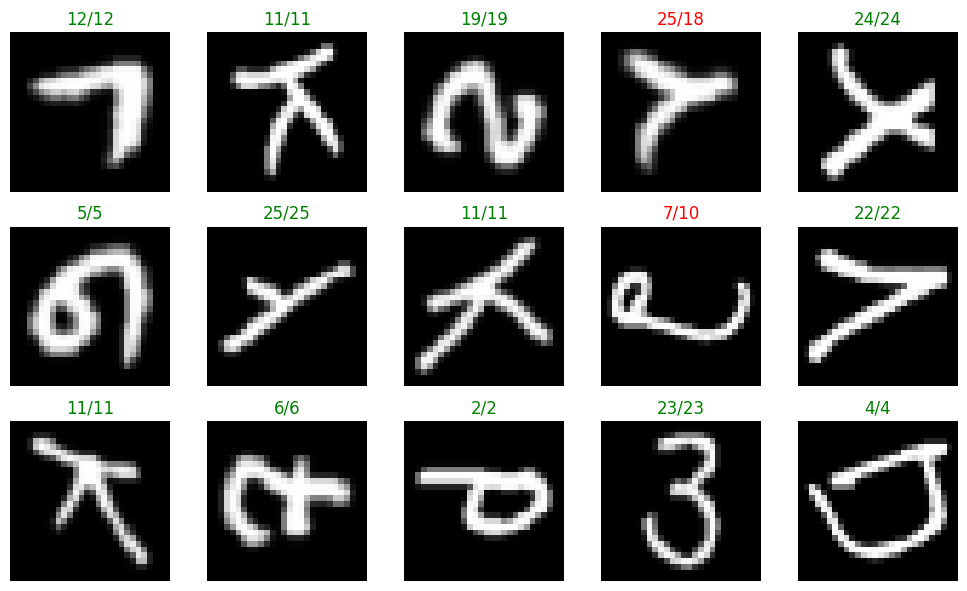

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()

Dropout: Es una técnica donde se desactiva aleatoriamente un subconjunto de neuronas durante el entrenamiento. Esto puede mejorar la generalización del modelo. La idea principal es ayudar a prevenir el sobreajuste (overfitting) al desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento.

Veamos cómo y por qué esto es beneficioso:

 Reducción de co-adaptaciones complejas: Sin dropout, durante el entrenamiento, las neuronas pueden comenzar a depender demasiado de la presencia de características específicas en las neuronas vecinas, es decir, pueden co-adaptarse a errores específicos. Al apagar aleatoriamente neuronas durante el entrenamiento, dropout reduce la dependencia de cualquier neurona individual, lo que obliga a la red a aprender características más robustas y redundantes.  

Podriamos varias las tecnicas de inicializacion: La inicialización de He, también conocida como inicialización de Kaiming, es una técnica para inicializar los pesos de las redes neuronales, particularmente útil cuando se utilizan funciones de activación ReLU o variantes de ReLU. Fue propuesta por Kaiming He et al. en un trabajo de 2015 sobre redes neuronales de convolución muy profundas.

La idea detrás de esta inicialización es evitar que las activaciones se vuelvan demasiado pequeñas o demasiado grandes durante las pasadas hacia adelante y hacia atrás a través de capas profundas. Si las activaciones o gradientes son demasiado grandes o pequeños, puede llevar a problemas de desvanecimiento o explosión de gradientes, lo que puede hacer que el entrenamiento de la red neuronal sea inestable o lento.